In [9]:
import os
import numpy as np

In [10]:
import pandas as pd

In [11]:
import matplotlib.pyplot as plt

In [12]:
from scipy.optimize import minimize

In [13]:
from sklearn.metrics import mean_squared_log_error

In [14]:
from sklearn.model_selection import TimeSeriesSplit

In [15]:
ads_col = 'Ads'
time_col = 'Time'

In [16]:
input_path = os.path.join('data', 'ads.csv')

In [18]:
ads = pd.read_csv(r'C:\Users\Chaitra\Desktop\ads.csv', index_col=time_col, parse_dates=[time_col])

In [19]:
print('dimension: ', ads.shape)

dimension:  (216, 1)


In [20]:
ads.head()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


C:\Users\Chaitra\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


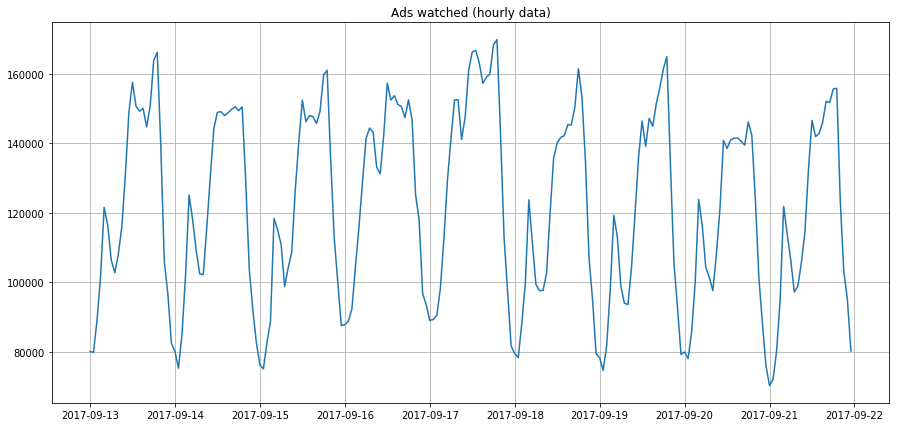

In [21]:
plt.figure(figsize=(15, 7))
plt.plot(ads[ads_col])
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

In [22]:
def average(series):
    return np.mean(series)


series = ads[ads_col]
average(series)

121974.05092592593

In [23]:
def moving_average(series, n):
    """Calculate average of last n observations"""
    return np.mean(series[-n:])


# prediction for the last observed day (past 24 hours)
moving_average(series, 24)

116805.0

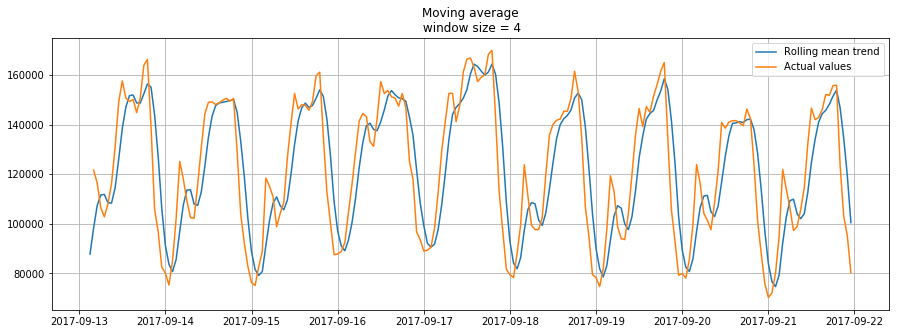

In [24]:
def plot_moving_avg(series, window):
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(15,5))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, label='Rolling mean trend')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)


plot_moving_avg(ads, window=4)

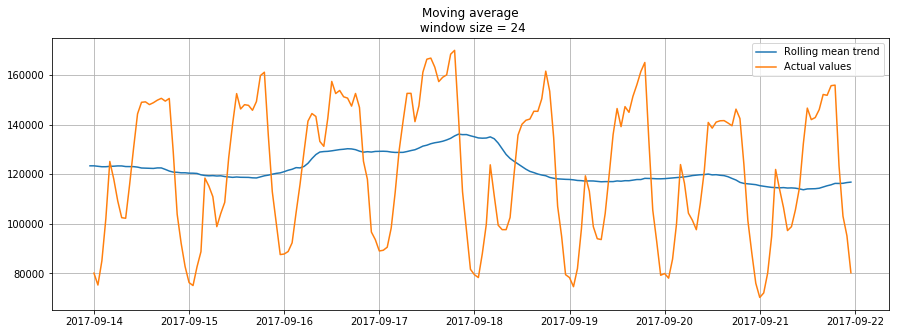

In [25]:
plot_moving_avg(ads, window=24)

In [26]:
def moving_average(arr, window):
    """
    http://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
    """
    ret = np.cumsum(arr)
    ret[window:] = ret[window:] - ret[:-window]
    return ret[window - 1:] / window


arr = np.arange(20)
print(moving_average(arr, window=4))

[ 1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5
 15.5 16.5 17.5]


In [27]:
def exponential_smoothing(series, alpha):
    """given a series and alpha, return series of expoentially smoothed points"""
    results = np.zeros_like(series)

    # first value remains the same as series,
    # as there is no history to learn from
    results[0] = series[0] 
    for t in range(1, series.shape[0]):
        results[t] = alpha * series[t] + (1 - alpha) * results[t - 1]

    return results

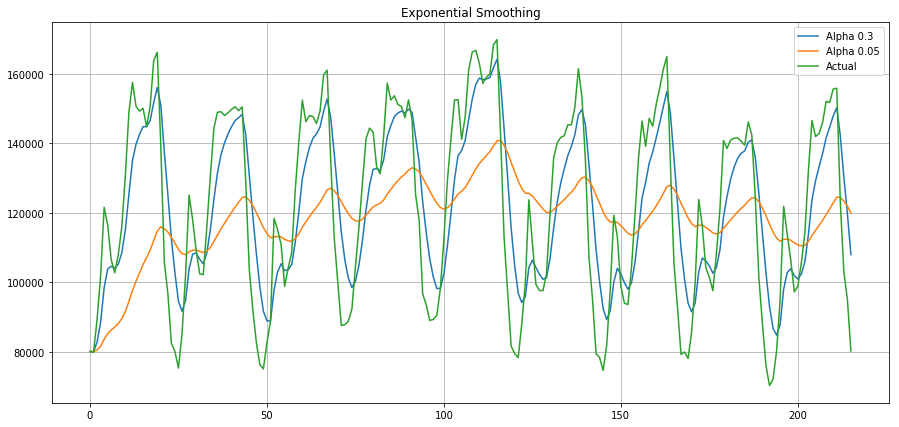

In [28]:
def plot_exponential_smoothing(series, alphas):
    """Plots exponential smoothing with different alphas."""  
    plt.figure(figsize=(15, 7))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label='Alpha {}'.format(alpha))

    plt.plot(series, label='Actual')
    plt.legend(loc='best')
    plt.axis('tight')
    plt.title('Exponential Smoothing')
    plt.grid(True)


plot_exponential_smoothing(series.values, [0.3, 0.05])

In [29]:
def double_exponential_smoothing(series, alpha, beta, n_preds=2):
    """
    Given a series, alpha, beta and n_preds (number of
    forecast/prediction steps), perform the prediction.
    """
    n_record = series.shape[0]
    results = np.zeros(n_record + n_preds)

    # first value remains the same as series,
    # as there is no history to learn from;
    # and the initial trend is the slope/difference
    # between the first two value of the series
    level = series[0]
    results[0] = series[0]
    trend = series[1] - series[0]
    for t in range(1, n_record + 1):
        if t >= n_record:
            # forecasting new points
            value = results[t - 1]
        else:
            value = series[t]

        previous_level = level
        level = alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - previous_level) + (1 - beta) * trend 
        results[t] = level + trend

    # for forecasting beyond the first new point,
    # the level and trend is all fixed
    if n_preds > 1:
        results[n_record + 1:] = level + np.arange(2, n_preds + 1) * trend

    return results

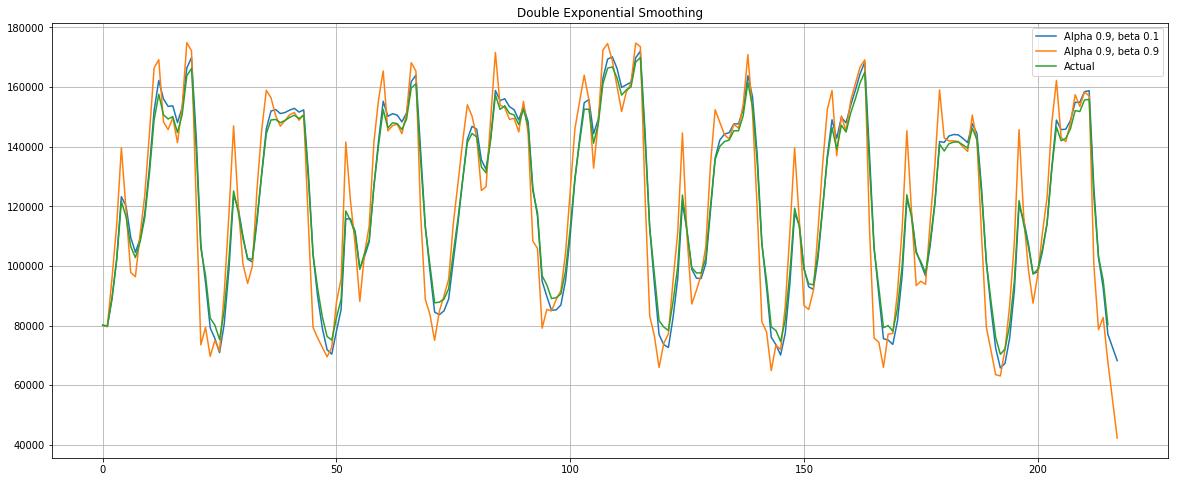

In [30]:
def plot_double_exponential_smoothing(series, alphas, betas):
    """Plots double exponential smoothing with different alphas and betas."""    
    plt.figure(figsize=(20, 8))
    for alpha, beta in zip(alphas, betas):
        results = double_exponential_smoothing(series, alpha, beta)
        plt.plot(results, label='Alpha {}, beta {}'.format(alpha, beta))

    plt.plot(series, label='Actual')
    plt.legend(loc='best')
    plt.axis('tight')
    plt.title('Double Exponential Smoothing')
    plt.grid(True)

plot_double_exponential_smoothing(series.values, alphas=[0.9, 0.9], betas=[0.1, 0.9])

In [31]:
def initial_trend(series, season_len):
    total = 0.0
    for i in range(season_len):
        total += (series[i + season_len] - series[i]) / season_len

    trend = total / season_len
    return trend


# we have a daily seasonality, which
# means our season length is 24 (the time
# interval in our time series is measured in hours)
season_len = 24
initial_trend(series, season_len)

-116.61458333333331

In [32]:
# given that we've defined the length for
# our season, we can figure out how many
# seasons are there in our time series
# and we need to compute the average values
# for each season
n_seasons = len(series) // season_len

season_averages = np.zeros(n_seasons)
for j in range(n_seasons):
    start_index = season_len * j
    end_index = start_index + season_len
    season_average = np.sum(series[start_index:end_index]) / season_len
    season_averages[j] = season_average

season_averages

array([123368.33333333, 120569.58333333, 120535.41666667, 129172.29166667,
       135468.75      , 117927.29166667, 118137.29166667, 115782.5       ,
       116805.        ])

In [33]:
# estimate the initial seasonal components
seasonals = np.zeros(season_len)
seasons = np.arange(n_seasons)
index = seasons * season_len
for i in range(season_len):
    seasonal = np.sum(series[index + i] - season_averages) / n_seasons
    seasonals[i] = seasonal

seasonals

array([-41795.16203704, -42882.93981481, -35750.71759259, -23279.05092593,
        -1682.93981481,  -3880.71759259,  -8801.27314815, -11805.71759259,
       -11071.8287037 ,  -6902.93981481,   4949.28240741,  20503.72685185,
        28525.94907407,  25725.94907407,  26472.06018519,  26142.61574074,
        26858.72685185,  28669.83796296,  35654.83796296,  34843.1712963 ,
        10056.50462963, -14126.8287037 , -27037.93981481, -39384.60648148])

In [34]:
class HoltWinters:
    """Scikit-learn like interface for Holt-Winters method."""

    def __init__(self, season_len=24, alpha=0.5, beta=0.5, gamma=0.5):
        self.beta = beta
        self.alpha = alpha
        self.gamma = gamma
        self.season_len = season_len

    def fit(self, series):
        # note that unlike scikit-learn's fit method, it doesn't learn
        # the optimal model paramters, alpha, beta, gamma instead it takes
        # whatever the value the user specified the produces the predicted time
        # series, this of course can be changed.
        beta = self.beta
        alpha = self.alpha
        gamma = self.gamma
        season_len = self.season_len
        seasonals = self._initial_seasonal(series)

        # initial values
        predictions = []
        smooth = series[0]
        trend = self._initial_trend(series)
        predictions.append(smooth)

        for i in range(1, len(series)):
            value = series[i]
            previous_smooth = smooth
            seasonal = seasonals[i % season_len]
            smooth = alpha * (value - seasonal) + (1 - alpha) * (previous_smooth + trend)
            trend = beta * (smooth - previous_smooth) + (1 - beta) * trend
            seasonals[i % season_len] = gamma * (value - smooth) + (1 - gamma) * seasonal
            predictions.append(smooth + trend + seasonals[i % season_len])

        self.trend_ = trend
        self.smooth_ = smooth
        self.seasonals_ = seasonals
        self.predictions_ = predictions
        return self
    
    def _initial_trend(self, series):
        season_len = self.season_len
        total = 0.0
        for i in range(season_len):
            total += (series[i + season_len] - series[i]) / season_len

        trend = total / season_len
        return trend

    def _initial_seasonal(self, series):
        season_len = self.season_len
        n_seasons = len(series) // season_len

        season_averages = np.zeros(n_seasons)
        for j in range(n_seasons):
            start_index = season_len * j
            end_index = start_index + season_len
            season_average = np.sum(series[start_index:end_index]) / season_len
            season_averages[j] = season_average

        seasonals = np.zeros(season_len)
        seasons = np.arange(n_seasons)
        index = seasons * season_len
        for i in range(season_len):
            seasonal = np.sum(series[index + i] - season_averages) / n_seasons
            seasonals[i] = seasonal

        return seasonals

    def predict(self, n_preds=10):
        """
        Parameters
        ----------
        n_preds: int, default 10
            Predictions horizon. e.g. If the original input time series to the .fit
            method has a length of 50, then specifying n_preds = 10, will generate
            predictions for the next 10 steps. Resulting in a prediction length of 60.
        """
        predictions = self.predictions_
        original_series_len = len(predictions)
        for i in range(original_series_len, original_series_len + n_preds):
            m = i - original_series_len + 1
            prediction = self.smooth_ + m * self.trend_ + self.seasonals_[i % self.season_len]
            predictions.append(prediction)

        return predictions

In [35]:
# a made-up example
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])
time_series_split = TimeSeriesSplit(n_splits=3) 

for train_index, test_index in time_series_split.split(X):
    print('TRAIN:', train_index, 'TEST:', test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [0] TEST: [1]
TRAIN: [0 1] TEST: [2]
TRAIN: [0 1 2] TEST: [3]


In [36]:
def timeseries_cv_score(params, series, loss_function, season_len=24, n_splits=3):
    """
    Iterating over folds, train model on each fold's training set,
    forecast and calculate error on each fold's test set.
    """
    errors = []    
    alpha, beta, gamma = params
    time_series_split = TimeSeriesSplit(n_splits=n_splits) 

    for train, test in time_series_split.split(series):
        model = HoltWinters(season_len, alpha, beta, gamma)
        model.fit(series[train])

        # evaluate the prediction on the test set only
        predictions = model.predict(n_preds=len(test))
        test_predictions = predictions[-len(test):]
        test_actual = series[test]
        error = loss_function(test_actual, test_predictions)
        errors.append(error)

    return np.mean(errors)

In [37]:
# provide initial values for model parameters' alpha, beta and gamma
# and leave out the last 20 points of our time series as test set
x = [0, 0, 0]
test_size = 20
data = series.values[:-test_size]
opt = minimize(timeseries_cv_score, x0=x, 
               args=(data, mean_squared_log_error), 
               method='TNC', bounds=((0, 1), (0, 1), (0, 1)))

print('original parameters: {}'.format(str(x)))
print('best parameters: {}'.format(str(opt.x)))

original parameters: [0, 0, 0]
best parameters: [0.1165268  0.0026777  0.05820974]


In [38]:
# retrieve optimal values, train the finnal model with them
# and generating forecast for next 50 hours
alpha_final, beta_final, gamma_final = opt.x
model = HoltWinters(season_len, alpha_final, beta_final, gamma_final)
model.fit(data)
predictions = model.predict(n_preds=50)

print('original series length: ', len(series))
print('prediction length: ', len(predictions))

original series length:  216
prediction length:  246


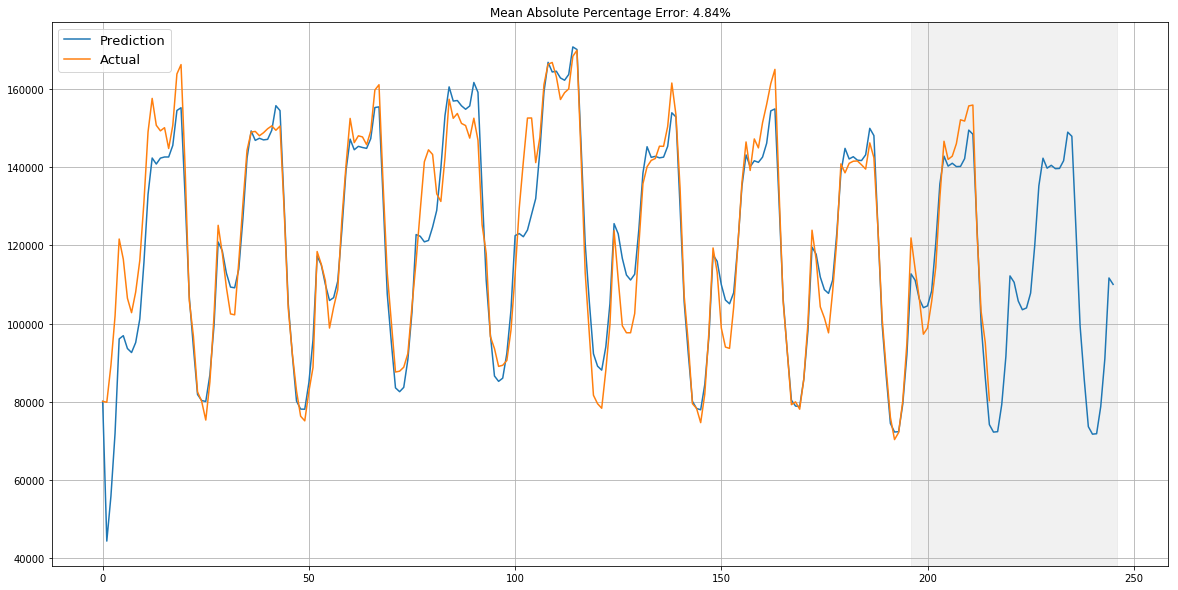

In [39]:
# more on this evaluation metric in the section below
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


data = series.values
error = mean_absolute_percentage_error(data, predictions[:len(series)])

plt.figure(figsize=(20, 10))
plt.plot(predictions, label='Prediction')
plt.plot(data, label='Actual')
plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
plt.axvspan(len(series) - test_size, len(predictions), alpha=0.3, color='lightgrey')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='best', fontsize=13)
plt.show()